In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 

#Load MNIST data
mnist  = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

#Reshape the images
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

#Convert labels to one-hot vectors
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)



In [2]:
#Build the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train the model
model.fit(train_images, train_labels, epochs=5, validation_split=0.1)

#Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

print(model.summary())

Epoch 1/5
1688/1688 [==============================] - 21s 12ms/step - loss: 0.1625 - accuracy: 0.9501 - val_loss: 0.0545 - val_accuracy: 0.9822
Epoch 2/5
1688/1688 [==============================] - 18s 11ms/step - loss: 0.0504 - accuracy: 0.9843 - val_loss: 0.0449 - val_accuracy: 0.9872
Epoch 3/5
1688/1688 [==============================] - 18s 11ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0372 - val_accuracy: 0.9893
Epoch 4/5
1688/1688 [==============================] - 19s 11ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.0411 - val_accuracy: 0.9877
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0268 - accuracy: 0.9920

Test accuracy: 0.9919999837875366
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 m

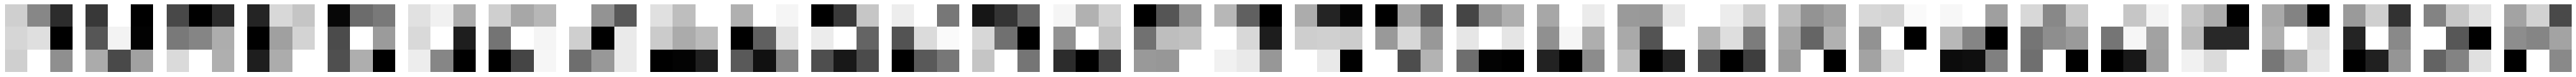

In [3]:
# Corrected function to visualize convolutional filters for grayscale images
def visualize_filters(layer):
    # Get the weights of the layer
    filters, biases = layer.get_weights()
    # Normalize filter values between 0 and 1 for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # Number of filters
    n_filters = filters.shape[-1]
    # Plot the filters
    fig, axes = plt.subplots(1, n_filters, figsize=(n_filters*2, 2))
    if n_filters == 1:
        axes = [axes]  # Ensures axes is iterable
    for i in range(n_filters):
        # Get the filter
        f = filters[:, :, :, i]
        # Plot the filter
        ax = axes[i]
        ax.imshow(f[:, :, 0], cmap='gray')  # Index 0 for the single channel
        ax.axis('off')
    plt.show()

# Visualizing filters of the first convolutional layer
visualize_filters(model.layers[0])


1/1 [==============================] - 0s 64ms/step


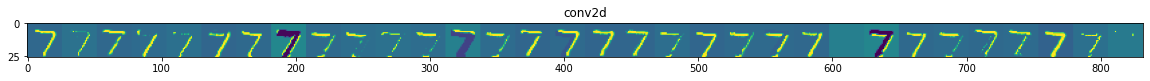

1/1 [==============================] - 0s 34ms/step


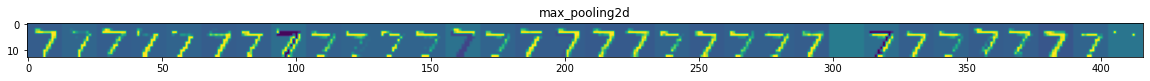

1/1 [==============================] - 0s 44ms/step


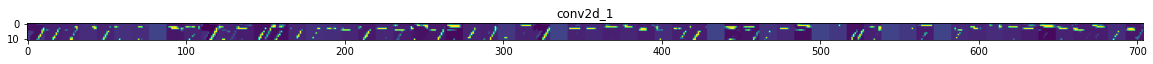

1/1 [==============================] - 0s 33ms/step


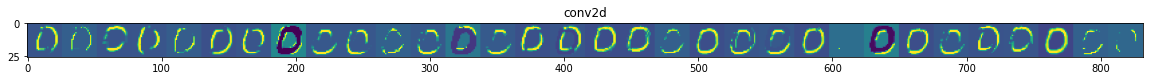

1/1 [==============================] - 0s 35ms/step


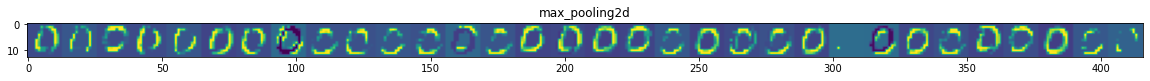

1/1 [==============================] - 0s 41ms/step


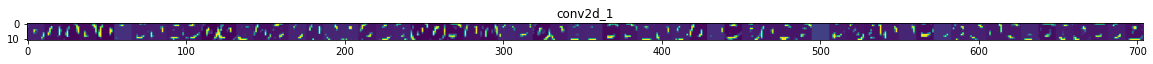

1/1 [==============================] - 0s 34ms/step


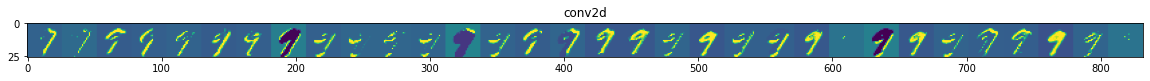

1/1 [==============================] - 0s 35ms/step


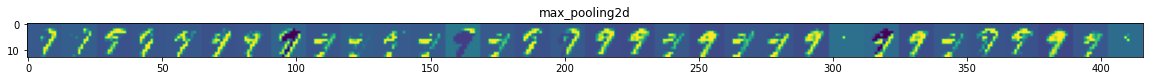

1/1 [==============================] - 0s 43ms/step


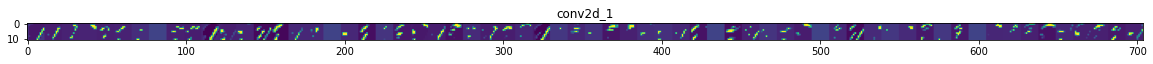

In [4]:
def visualize_feature_maps(model, layer_name, image_index):
    # Load an image and preprocess it
    img = test_images[image_index].reshape(1, 28, 28, 1)
    
    # Define a new model to get the output of the specified layer
    layer_output = model.get_layer(layer_name).output
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    
    # Get the feature map for the specified layer
    feature_map = feature_map_model.predict(img)

    # Check if the layer is a Dense layer (no spatial dimensions)
    if len(feature_map.shape) == 2:
        # Dense layer, reshape to add spatial dimensions (1x1)
        feature_map = np.expand_dims(np.expand_dims(feature_map, axis=1), axis=1)

    # Get number of features/filters
    num_features = feature_map.shape[-1]
    size = feature_map.shape[1]

    # Create a grid to display the feature maps
    display_grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        x = feature_map[0, :, :, i]
        x -= x.mean()
        std = x.std()
        if std != 0:
            x /= std
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size: (i + 1) * size] = x

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Visualizing feature maps of the first convolutional layer
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1']
image_indices = [0, 10, 20]

for image_index in image_indices:
    for layer_name in layer_names:
        visualize_feature_maps(model, layer_name, image_index)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


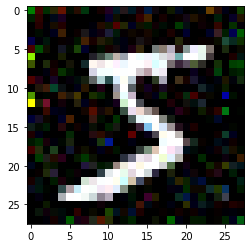

In [5]:
#implementing deep dream
import tensorflow as tf
import keras.applications.inception_v3 as inception_v3
import keras.preprocessing.image as image

# Function to preprocess MNIST images for InceptionV3
def preprocess_mnist_image(img):
    img = tf.image.resize(img, (299, 299))  # Resize to match Inception's input size
    img = tf.image.grayscale_to_rgb(img)    # Convert grayscale to RGB
    img = inception_v3.preprocess_input(img * 255)  # Scale pixel values
    return img

# Load the InceptionV3 model
inception_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# Define layers to maximize properly
names = ['mixed2', 'mixed3', 'mixed4']
layers = [inception_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=inception_model.input, outputs=layers)

# DeepDream function
def deepdream(model, img, step_size, steps):
    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            outputs = model(img)
            loss = tf.reduce_mean([tf.reduce_mean(tf.square(out)) for out in outputs])
        gradients = tape.gradient(loss, img)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-7)
        img += gradients * step_size
    return img

# Select and preprocess an MNIST image
mnist_image = train_images[0].reshape((28, 28, 1))  # Use your MNIST image here
mnist_image = preprocess_mnist_image(mnist_image)

# Apply DeepDream to the MNIST image
dreamed_image = deepdream(dream_model, tf.expand_dims(mnist_image, axis=0), step_size=0.01, steps=100)

# Post-process and display the image
dreamed_image = np.squeeze(dreamed_image, axis=0)
dreamed_image = (dreamed_image + 1) / 2  # Rescale to [0, 1]
dreamed_image = tf.image.resize(dreamed_image, (28, 28))  # Resize back to MNIST size
plt.imshow(dreamed_image)
plt.show()

In [6]:
model.save('mnist_cnn.h5')

In [7]:
from flask import Flask, request, jsonify
import tensorflow as tf
from PIL import Image
import io

# Load the trained model
model = tf.keras.models.load_model('mnist_cnn.h5')

app = Flask(__name__)

@app.route('/')
def preprocess_image(image):
    """Preprocess the input image to fit the model's requirements"""
    image = image.resize((28, 28))  # Resize image to 28x28
    image = image.convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image / 255.0  # Normalize pixel values
    image = image.reshape(1, 28, 28, 1)  # Reshape for the model
    return image

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'}), 400

    file = request.files['file']
    if file:
        image = Image.open(io.BytesIO(file.read()))
        processed_image = preprocess_image(image)
        prediction = model.predict(processed_image)
        digit = np.argmax(prediction)
        return jsonify({'digit': int(digit)})

    return jsonify({'error': 'Error processing file'}), 500

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\aniru\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
